Challenge: Write a Churn Simulator
==================================

- Start with a single customer in a random initial state (A, B, C)
- Change the state randomly using a transition probability matrix P
- Simulate N time steps in the same way
- write the sequence of states to an output file

--------------------------------------

- Do the same but for M customers
- Add new customers to the system at every time step

--------------------------------------

- Plot the number of customers in each state
- Try to find a steady state

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#### 1) Write the functions

Write a function that does the following (it ended up to be three functions):

* Does the following 4 steps for each customer.

    1) creates an inital state from the list of all possible initial states.

    3) Calculates the transition probabilities given the initial state and the transition probability matrix and simulates the transition.

    3) Does the same for N specified periods.

    4) Function returns the result to a DataFrame or file which is appendable.


* Adds new customers to the market each period.

In [2]:
def transition_with_new_customers(initial_states, possible_states, transition_probabilities, total_nr_of_periods,\
                              nr_of_simulations, input_frame, new_customers_per_period):
    '''
    This function takes the following input parameters:
    
    - a couple of inputs to pass them on to the 'simulate' function:
        - initial_states: a list of possible initial states
        - possible_states: a list of possible states (after the initial stage)
        - transition probabilites: transition probabilites between states (as DataFrame)
        - total_nr_of_periods: the total nr. of periods that are simulated
        - nr_of_simulations: nr. of customer journeys we are going to simulate
        - the frame containing the current output as input_frame
    
    and additionally:
    - new_customers_per_period: number of customers that are added each period

    and it appends the purchase history of the market to the output DataFrame
    '''
    
    output_frame = pd.DataFrame()
    
    # run the simulation for all initial customers M
    output_frame = pd.concat([output_frame\
                                  , market_transition(initial_states, possible_states, transition_probabilities\
                                  , total_nr_of_periods, 0, nr_of_simulations, input_frame)], axis=1)
    
    
    # run the simulation for all new customers NC each period
    for i in range(total_nr_of_periods-1):
        
        #print(f'The total number of periods is: {total_nr_of_periods  -  i}')
        #print(output_frame)
        output_frame = pd.concat([output_frame\
                                  , market_transition(initial_states, possible_states, transition_probabilities\
                                  , total_nr_of_periods-i-1, i+1, new_customers_per_period, input_frame)], axis=1)
        
    return output_frame

In [3]:
# create a random initial state
def market_transition(initial_states, possible_states, transition_probabilities, total_nr_of_periods,\
             periods_run, nr_of_simulations, input_frame):
    
    '''
    The function market_transition takes the following input paramter:
    
    - initial_states: a list of possible initial states
    - possible_states: a list of possible states (after the initial stage)
    - transition probabilites: transition probabilites between states (as DataFrame)
    - total_nr_of_periods: the nr. of periods that are simulated
    - periods_run: number of periods that have already run when the function is called
    - nr_of_simulations: nr. of customer journeys we are going to simulate
    - the frame containing the current output as input_frame
    
    and returns:
    
    - The purchase history to the output DataFrame
    '''
    
    # create output_frame
    output_frame = input_frame
    
    
    # do all the steps for the number of customers M specified in the beginning
    for m in range(nr_of_simulations):
        
        
        # create a list to store the history
        history = [None] * periods_run
        
        # create the initial state of customer m and save it in the history list
        state = np.asscalar(np.random.choice(initial_states, size=1))
        history.append(state)
        
        # call the function for the customer_transition for customer m
        history = customer_transition(total_nr_of_periods, state, possible_states, transition_probabilities, history)
        
        # append to the output DataFrame
        history = pd.DataFrame(history)
        output_frame = pd.concat([output_frame, history], axis=1)
    
    
    return output_frame

In [4]:
def customer_transition(total_nr_of_periods, state, possible_states, transition_probabilities, history):
    
    '''
    The function customer_transition takes the following input parameters:
    
    - total_nr_of_periods: the nr. of periods that are simulated
    - state: current state
    - possible_states: a list of possible states (after the initial stage)
    - transition probabilites: transition probabilites between states (as DataFrame)
    - history: A list saving the purchase history for each customer
    
    and returns:
    
    - state: the new state of the customer after transition
    
    '''
    
    # calculate the random transition of the customer between each customer for the lifetime of the market
    for i in range(total_nr_of_periods):
        
        # retrieve the transition probabilities for the current state from the transition matrix
        transition_prob = transition_probabilities.loc[state]

        # simulate the transition to a new state and save it
        state = np.asscalar(np.random.choice(possible_states, p=transition_prob, size=1))
        history.append(state)
    
    return history

#### 2) Set all the global variables and load data

In [5]:
# create a list that contains all the possible states
STATES = ['Apple', 'Banana', 'Coffee', 'Doughnut', 'churned']

# create a list of all possible initial states
INIT_STATES = ['Apple', 'Banana', 'Coffee', 'Doughnut']

# create a dictionary for the translation between state and vectorized state
D = {'Apple': 0, 'Banana': 1, 'Coffee': 2, 'Doughnut': 3, 'churned': 4}

# chose the number of periods for the simmulation
N = 30

# chose the number of simulations to run (initial nr. of customers)
M = 100

# New customers per period
NC = int(M * 0.7)

# create a dataframe for the output
output = pd.DataFrame()

# load and initialize the transition matrix
cust = pd.read_csv('./data/customer_matrix.csv', index_col=0)
trans = pd.read_csv('./data/transition_probabilities.csv', index_col=0)

# Add the probabilites from the state 'churned'
churn_row = pd.DataFrame([[0, 0, 0, 0, 1]], columns=trans.columns)
trans = trans.append(churn_row)
trans = trans.rename({0: 'churned'}, axis='index')

#### 3) Run the simulation:

In [7]:
output = transition_with_new_customers(INIT_STATES, STATES, trans, N, M, output, NC)

In [8]:
# translate the numerical values
#for i, row in output.iterrows():
#    for r in row.index:
#        output.at[i, r] = float(D[output.at[i, r]])

In [9]:
output = output.T.reset_index(drop=True)

In [16]:
output.columns

RangeIndex(start=0, stop=31, step=1)

In [17]:
# create a dataframe containing the number of instances for each state in each period
num = pd.DataFrame()

for c in output.columns:
    
    counts = []
    name = ''
    
    for state in STATES:

        out = output[c].str.count(state).sum()
        counts.append(out)

    counts = pd.Series(counts, name=f'{c}')
    num = pd.concat([num, counts], axis=1)

In [18]:
num

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
0,20.0,26.0,26.0,24.0,24.0,29.0,23.0,24.0,24.0,24.0,...,21.0,25.0,32.0,36.0,24.0,18.0,37.0,39.0,25,11
1,18.0,35.0,45.0,34.0,43.0,25.0,38.0,42.0,35.0,24.0,...,46.0,32.0,26.0,32.0,30.0,40.0,31.0,30.0,25,14
2,27.0,30.0,29.0,41.0,32.0,39.0,34.0,34.0,31.0,33.0,...,31.0,35.0,34.0,30.0,38.0,33.0,26.0,26.0,33,13
3,35.0,24.0,24.0,28.0,22.0,28.0,35.0,24.0,30.0,32.0,...,27.0,27.0,26.0,20.0,22.0,36.0,24.0,30.0,33,8
4,0.0,55.0,116.0,183.0,259.0,329.0,390.0,466.0,540.0,617.0,...,1445.0,1521.0,1592.0,1662.0,1736.0,1793.0,1872.0,1935.0,2014,2084


In [19]:
# inverse the dictionary D
inv_D = {v: k for k, v in D.items()}
inv_D

{0: 'Apple', 1: 'Banana', 2: 'Coffee', 3: 'Doughnut', 4: 'churned'}

In [20]:
# rename the indices of the matrix
num = num.rename(mapper=inv_D, axis='index').drop('churned', axis=0)
num

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
Apple,20.0,26.0,26.0,24.0,24.0,29.0,23.0,24.0,24.0,24.0,...,21.0,25.0,32.0,36.0,24.0,18.0,37.0,39.0,25,11
Banana,18.0,35.0,45.0,34.0,43.0,25.0,38.0,42.0,35.0,24.0,...,46.0,32.0,26.0,32.0,30.0,40.0,31.0,30.0,25,14
Coffee,27.0,30.0,29.0,41.0,32.0,39.0,34.0,34.0,31.0,33.0,...,31.0,35.0,34.0,30.0,38.0,33.0,26.0,26.0,33,13
Doughnut,35.0,24.0,24.0,28.0,22.0,28.0,35.0,24.0,30.0,32.0,...,27.0,27.0,26.0,20.0,22.0,36.0,24.0,30.0,33,8


Text(0,0.5,'Nr. of purchases')

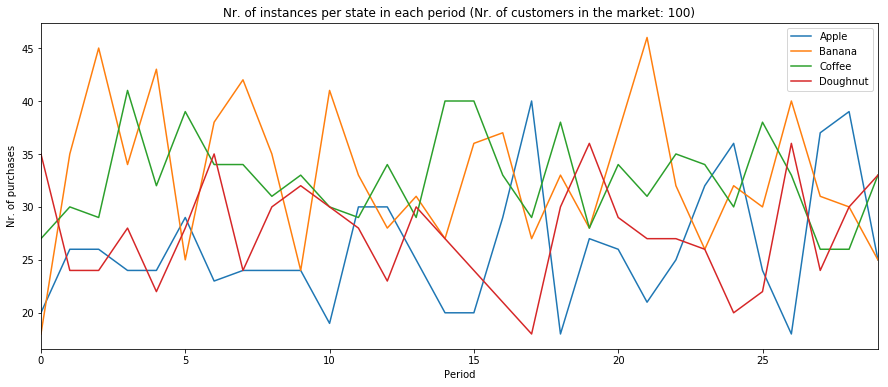

In [21]:
num.iloc[:,:-1].T.plot(figsize = (15, 6)\
          , title='Nr. of instances per state in each period (Nr. of customers in the market: {})'.format(M))\

plt.xlabel('Period')
plt.ylabel('Nr. of purchases')